In [10]:
from keras import optimizers, losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,concatenate
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras.utils import plot_model

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle 

import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import time 
import sys

In [5]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [3]:
df =pd.read_csv("../../../data/full_data_small_datased.csv")
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [4]:
len(df[df["Class"]==0]),len(df[df["Class"]==1])

(40395, 237665)

In [11]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [12]:
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [13]:
def normaliser_all_columns(df):
    diction={}
    
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [14]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [15]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [16]:
def add_noise(xtrain,xtest,ytrain,ytest):
    noise_factor=0.3
    xtrain_noise=xtrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtrain.shape)
    xtest_noise=xtest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtest.shape)
    ytrain_noise=ytrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytrain.shape)
    ytest_noise=ytest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytest.shape)
    xtrain_noise=np.clip(xtrain_noise,0.,1.)
    xtest_noise=np.clip(xtest_noise,0.,1.)
    ytrain_noise=np.clip(ytrain_noise,0.,1.)
    ytest_noise=np.clip(ytest_noise,0.,1.)
    return xtrain_noise,xtest_noise,ytrain_noise,ytest_noise

In [20]:
xtrain_noise,xtest_noise,ytrain_noise,ytest_noise=add_noise(xtrain,xtest,ytrain,ytest)

In [17]:
def create_mlp_dae(input_dim):
    '''
    I) For the DAE we will have as number neurons fo each layer :
        1) Encoder :
            L1(input_dim), L2(input_dim/2), L3(input_dim/4), L4(input_dim/8), L5(10)
        2) The bottleneck with be composed of 3 neurons : L6(3)
        3) Decoder : 
            L6(10), L7(input_dim/8), L8(input_dim/4), L9(input_dim/2), L10(input_dim)
    
    II) For the mlp we will have as number neurons fo each layer :
        L1(input_dim), L2(input_dim*2), L3(input_dim*4), L4(input_dim*5), L5(input_dim*4), L6(input_dim*2), L7(input_dim), L8(input_dim/2)     
    
    III) For the combination mlp_DAE we will have as number neurons fo each layer :
        L1(output_DAE+output_mlp), L2(input_dim/2), L3(input_dim/4), L4(input_dim/8), L5(input_dim/16), L6(input_dim/32), L7(1)
    '''
    
    
    ############################
    #Define the DAE architecture
    ############################
    
    dae_input=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=input_dim,activation="tanh")(dae_input) 
    encoded= Dense(units=int(input_dim/2),activation="tanh")(encoded) 
    encoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    encoded= Dense(units=10,activation="tanh")(encoded)
    encoded= Dense(units=3,activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/2),activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="softmax",name='decoded')(decoded) #softmax return a vector of probabilty describing the importance of each attribute 

    ############################
    #Define the MLP architecture
    ############################
    
    output_mlp = input_dim/2
    mlp_input = Input(shape=(input_dim, ))
    
    mlp = Dense(input_dim, activation='relu')(mlp_input)
    mlp = Dense(input_dim*2, activation='relu' )(mlp)
    mlp = Dropout(0.1)(mlp)# To deactivate 10% of neurons, to avoid the overfitting
    mlp = Dense(input_dim*4, activation='relu')(mlp)
    mlp = Dropout(0.1)(mlp)
    mlp = Dense(input_dim*5, activation='relu')(mlp)
    mlp = Dropout(0.1)(mlp)
    mlp = Dense(input_dim*4, activation='relu')(mlp)
    mlp = Dropout(0.1)(mlp)
    mlp = Dense(input_dim*2, activation='relu')(mlp)
    mlp = Dropout(0.1)(mlp)
    mlp = Dense(input_dim, activation='relu')(mlp)
    mlp = Dropout(0.1)(mlp)
    mlp = Dense(int(input_dim/2), activation='relu')(mlp)

    ############################
    #Define the concatenate layer
    ############################

    merge_layer = concatenate([mlp, decoded])

    ############################
    #Define the rest of layers
    ############################

    combination = Dense(int(input_dim+ output_mlp/2), activation='relu')(merge_layer)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_dim+ output_mlp/4), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_dim+ output_mlp/8), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_dim+ output_mlp/16), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_dim+ output_mlp/32), activation='relu')(combination)
    combination = Dense(1, activation='sigmoid')(combination)

    ############################
    #Create, Compile and plot the model
    ############################

    mlp_dae = Model(inputs=[dae_input, mlp_input], outputs=combination)
    mlp_dae.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    plot_model(mlp_dae,to_file='mlp_dae.png',show_shapes=True)
    
    
    return mlp_dae

In [18]:
cobinaison_model = create_mlp_dae(xtrain.shape[1])

In [21]:
#hyperparametrs :
batchsize=100
epoch=10
start_time = time.time() 
cobinaison_model.fit([xtrain_noise,xtrain],ytrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=([xtest_noise,xtest],ytest),
              callbacks=[TensorBoard(log_dir="../logs/DAE_MLP")])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 122s 550us/step - loss: 0.0016 - mae: 0.0024 - val_loss: 3.6401e-05 - val_mae: 3.9194e-05
Epoch 2/10
222448/222448 [==============================] - 116s 521us/step - loss: 3.1229e-04 - mae: 3.4262e-04 - val_loss: 3.5963e-05 - val_mae: 3.5965e-05
Epoch 3/10
222448/222448 [==============================] - 114s 512us/step - loss: 4.5019e-05 - mae: 4.6276e-05 - val_loss: 7.0530e-05 - val_mae: 7.1220e-05
Epoch 4/10
222448/222448 [==============================] - 85s 382us/step - loss: 4.0633e-05 - mae: 4.1494e-05 - val_loss: 3.5963e-05 - val_mae: 3.5963e-05
Epoch 5/10
222448/222448 [==============================] - 86s 384us/step - loss: 4.0459e-05 - mae: 4.0459e-05 - val_loss: 3.5963e-05 - val_mae: 3.5963e-05
Epoch 6/10
222448/222448 [==============================] - 86s 388us/step - loss: 4.0459e-05 - mae: 4.0459e-05 - val_loss: 3.5963e-05 - val_mae: 3.5963e-05
Epoch 7/10
2

In [22]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/DAE_MLP/"}

## Test the model by usign the predict method

In [28]:
start_time = time.time() 
y_pred=cobinaison_model.predict([xtest_noise,xtest_noise]) # Predict
print("--- %s seconds ---" % (time.time() - start_time))
y_pred = np.round( y_pred)

--- 9.407182931900024 seconds ---


## Get all possible metrics to evaluate the model

In [35]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8033
         1.0       1.00      1.00      1.00     47579

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [36]:
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9997124286011394
accuracy_score : 0.999712292311012
recall_score : 0.999712292311012
f1_score : 0.9997123369435454
roc_auc_score : 0.9995731865497016
True_positive : 47568, False_positive : 5, True_negative : 8028, False_negative : 11


## Plot the confusion matrics

In [37]:
viz=Visualization()

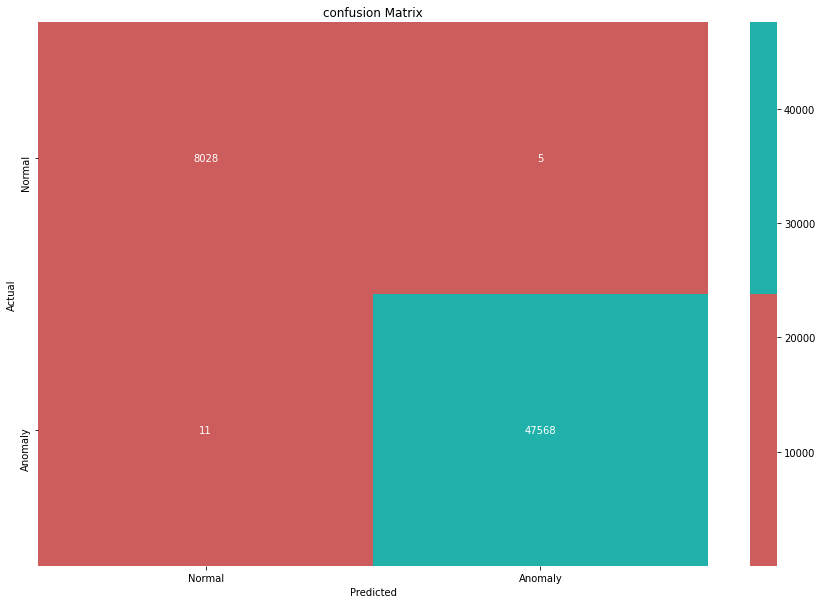

In [38]:
viz.drow_confusion_matrix(ytest,y_pred)

## Save the model

In [39]:
cobinaison_model.save("./models/mlp_dae.h5")